In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import causal_convolution_layer
import Dataloader

In [2]:
import math
from torch.utils.data import DataLoader

In [3]:
train_dataset = Dataloader.time_series_decoder_paper(96,4500)
validation_dataset = Dataloader.time_series_decoder_paper(96,500)
test_dataset = Dataloader.time_series_decoder_paper(96,1000)

x: 4500*120 fx: 4500*120
x: 500*120 fx: 500*120
x: 1000*120 fx: 1000*120


In [4]:
criterion = torch.nn.MSELoss()

In [5]:
train_dl = DataLoader(train_dataset,batch_size=32,shuffle=True)
validation_dl = DataLoader(validation_dataset,batch_size=64)
test_dl = DataLoader(test_dataset,batch_size=128)

In [6]:
len(train_dataset[0][0][96:])

24

# LSTM ATTEMPT

In [7]:
class LSTM_Time_Series(torch.nn.Module):
    def __init__(self,input_size=2,embedding_size=256,kernel_width=9,hidden_size=512):
        super(LSTM_Time_Series,self).__init__()
        
        self.input_embedding = causal_convolution_layer.context_embedding(input_size,embedding_size,kernel_width)    
        
        self.lstm = torch.nn.LSTM(embedding_size,hidden_size,batch_first=True)
        
        self.fc1 = torch.nn.Linear(hidden_size,1)
        
    def forward(self,x,y):
        """
        x: the time covariate
        y: the observed target
        """
        # concatenate observed points and time covariate
        # (B,input size + covariate size,sequence length)
        z_obs = torch.cat((y.unsqueeze(1),x.unsqueeze(1)),1)

        # input_embedding returns shape (B,embedding size,sequence length)
        z_obs_embedding = self.input_embedding(z_obs)
        
        # permute axes (B,sequence length, embedding size)
        z_obs_embedding = self.input_embedding(z_obs).permute(0,2,1)
                
        # all hidden states from lstm
        # (B,sequence length,num_directions * hidden size)
        lstm_out,_ = self.lstm(z_obs_embedding)
        
        # input to nn.Linear: (N,*,Hin)
        # output (N,*,Hout)
        return self.fc1(lstm_out)

In [8]:
criterion_LSTM = torch.nn.MSELoss()

In [9]:
LSTM = LSTM_Time_Series().cuda()

In [10]:
lr = .0005 # learning rate
optimizer = torch.optim.Adam(LSTM.parameters(), lr=lr)
epochs = 100

In [11]:
def Dp(y_pred,y_true,q):
    return max([q*(y_pred-y_true),(q-1)*(y_pred-y_true)])

def Rp_num_den(y_preds,y_trues,q):
    numerator = np.sum([Dp(y_pred,y_true,q) for y_pred,y_true in zip(y_preds,y_trues)])
    denominator = np.sum([np.abs(y_true) for y_true in y_trues])
    return numerator,denominator

In [16]:
def train_epoch(LSTM,train_dl,t0=96):
    LSTM.train()
    train_loss = 0
    n = 0
    for step,(x,y,_) in enumerate(train_dl):
        x = x.cuda()
        y = y.cuda()
        
        optimizer.zero_grad()
        output = LSTM(x,y)
        loss = criterion(output.squeeze()[:,(t0-1):(t0+24-1)],y.cuda()[:,t0:])        
        loss.backward()
        optimizer.step()
        
        train_loss += (loss.detach().cpu().item() * x.shape[0])
        n += x.shape[0]
    return train_loss/n

In [20]:
def eval_epoch(LSTM,validation_dl,t0=96):
    LSTM.eval()
    eval_loss = 0
    n = 0
    with torch.no_grad():
        for step,(x,y,_) in enumerate(train_dl):
            x = x.cuda()
            y = y.cuda()

            output = LSTM(x,y)
            loss = criterion(output.squeeze()[:,(t0-1):(t0+24-1)],y.cuda()[:,t0:])        
        
            eval_loss += (loss.detach().cpu().item() * x.shape[0])
            n += x.shape[0]
            
    return eval_loss/n

In [23]:
def test_epoch(LSTM,test_dl,t0=96):
    with torch.no_grad():
        predictions = []
        observations = []

        LSTM.eval()
        for step,(x,y,_) in enumerate(train_dl):
            x = x.cuda()
            y = y.cuda()

            output = LSTM(x,y)

            for p,o in zip(output.squeeze()[:,(t0-1):(t0+24-1)].cpu().numpy().tolist(),y.cuda()[:,t0:].cpu().numpy().tolist()):

                predictions.append(p)
                observations.append(o)

        num = 0
        den = 0
        for y_preds,y_trues in zip(predictions,observations):
            num_i,den_i = Rp_num_den(y_preds,y_trues,.5)
            num+=num_i
            den+=den_i
        Rp = (2*num)/den
        
    return Rp

In [24]:
train_epoch_loss = []
eval_epoch_loss = []
Rp_best = 10
for e,epoch in enumerate(range(epochs)):
    train_loss = []
    eval_loss = []
    
    l_train = train_epoch(LSTM,train_dl)
    train_loss.append(l_train)
    
    l_eval = eval_epoch(LSTM,validation_dl)
    eval_loss.append(l_eval)
            
    Rp = test_epoch(LSTM,test_dl)
    
    if Rp_best > Rp:
        Rp_best = Rp

    with torch.no_grad():
        print("Epoch {}: Train loss={} \t Eval loss = {} \t Rp={}".format(e,np.mean(train_loss),np.mean(eval_loss),Rp))
        
        train_epoch_loss.append(np.mean(train_loss))
        eval_epoch_loss.append(np.mean(eval_loss))

Epoch 0: Train loss=931.8386131727431 	 Eval loss = 902.5100592990451 	 Rp=0.35420285470804513
Epoch 1: Train loss=898.192623860677 	 Eval loss = 895.0723541124132 	 Rp=0.3519585324165268
Epoch 2: Train loss=785.5823402777778 	 Eval loss = 454.04180560980905 	 Rp=0.22379531432090632
Epoch 3: Train loss=228.33513615587023 	 Eval loss = 124.75557482910156 	 Rp=0.08848298635607509
Epoch 4: Train loss=87.8933021375868 	 Eval loss = 60.40662610880534 	 Rp=0.06038000598736438
Epoch 5: Train loss=44.626654524061415 	 Eval loss = 31.639441833496093 	 Rp=0.04394083041339666
Epoch 6: Train loss=24.75927567884657 	 Eval loss = 18.87621740468343 	 Rp=0.03499193709915784
Epoch 7: Train loss=15.507839687771268 	 Eval loss = 12.680300285339355 	 Rp=0.030059860650706156
Epoch 8: Train loss=10.77847634294298 	 Eval loss = 9.057627142164442 	 Rp=0.026143892203727544
Epoch 9: Train loss=8.036535350375706 	 Eval loss = 7.232348187764486 	 Rp=0.024657618098944213
Epoch 10: Train loss=6.478422111511231 	 Ev

Epoch 85: Train loss=2.3535662549336753 	 Eval loss = 2.2349119981129966 	 Rp=0.015250511077282593
Epoch 86: Train loss=2.3798094064924453 	 Eval loss = 2.3007770790523954 	 Rp=0.015500830301239757
Epoch 87: Train loss=2.3364432267083064 	 Eval loss = 2.3381012070973712 	 Rp=0.01566594184942022
Epoch 88: Train loss=2.335901609208849 	 Eval loss = 2.496857656902737 	 Rp=0.016196769137874854
Epoch 89: Train loss=2.3326174009111194 	 Eval loss = 2.3011999855041503 	 Rp=0.015525667967488175
Epoch 90: Train loss=2.3161577712164987 	 Eval loss = 2.295529117796156 	 Rp=0.015579123412296553
Epoch 91: Train loss=2.331868735207452 	 Eval loss = 2.256237250434028 	 Rp=0.015347738101044063
Epoch 92: Train loss=2.3158297032250297 	 Eval loss = 2.3166277440389 	 Rp=0.015624455275874406
Epoch 93: Train loss=2.3025298438602024 	 Eval loss = 2.2762691769070096 	 Rp=0.015453548124189339
Epoch 94: Train loss=2.325308758629693 	 Eval loss = 2.3548189324273006 	 Rp=0.015704463373693533
Epoch 95: Train loss

In [25]:
print("Best Rp={}".format(Rp_best))

Best Rp=0.01514553921179006


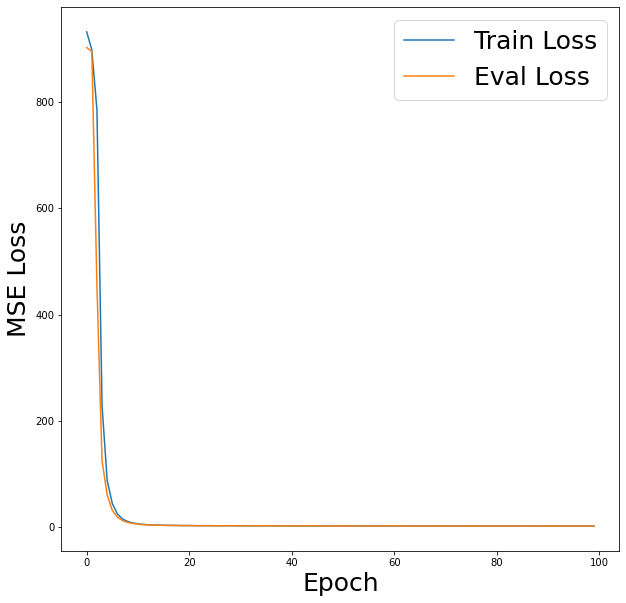

In [26]:
plt.figure(figsize=(10,10))
plt.plot(train_epoch_loss)
plt.plot(eval_epoch_loss)
plt.legend(['Train Loss','Eval Loss'],fontsize=25)
plt.xlabel("Epoch",fontsize=25)
plt.ylabel("MSE Loss",fontsize=25)
plt.show()

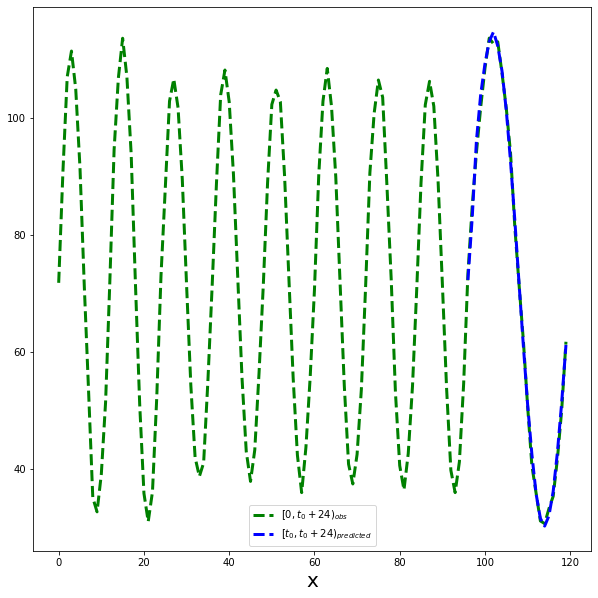

C:\Users\lpott\anaconda3\envs\NLP\lib\site-packages\torch\nn\functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


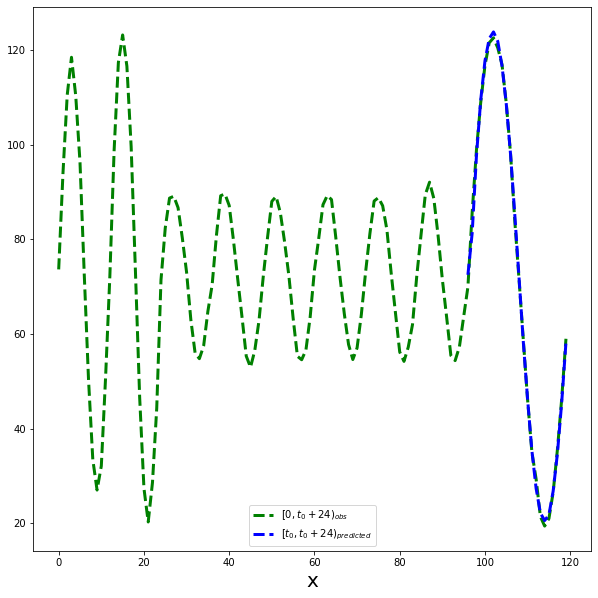

C:\Users\lpott\anaconda3\envs\NLP\lib\site-packages\torch\nn\functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


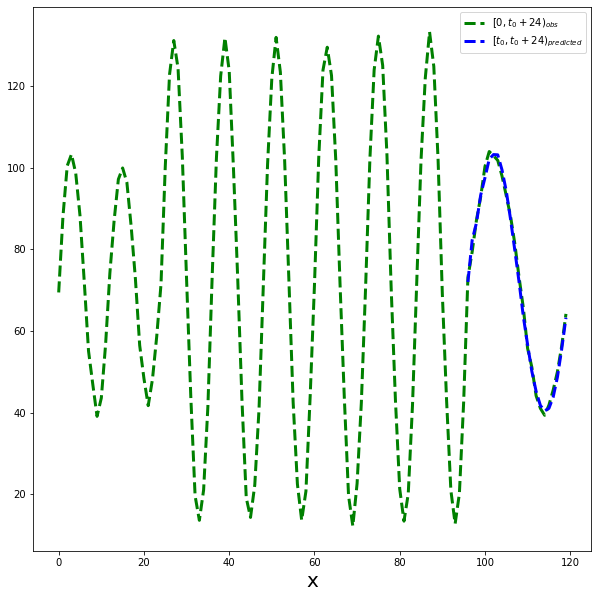

C:\Users\lpott\anaconda3\envs\NLP\lib\site-packages\torch\nn\functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


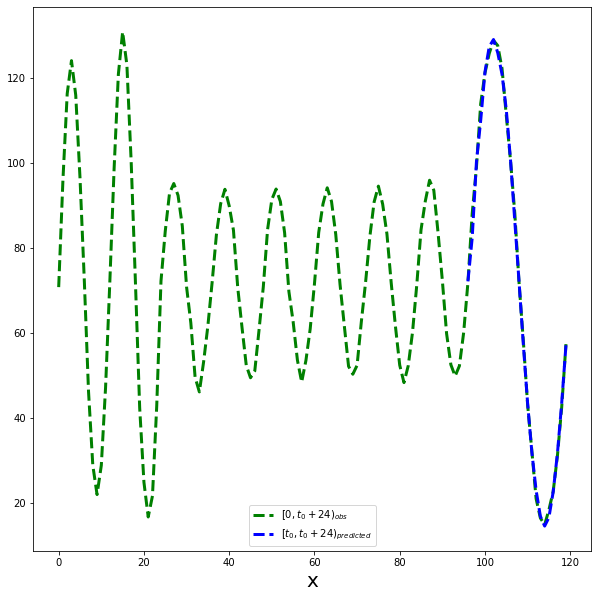

C:\Users\lpott\anaconda3\envs\NLP\lib\site-packages\torch\nn\functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


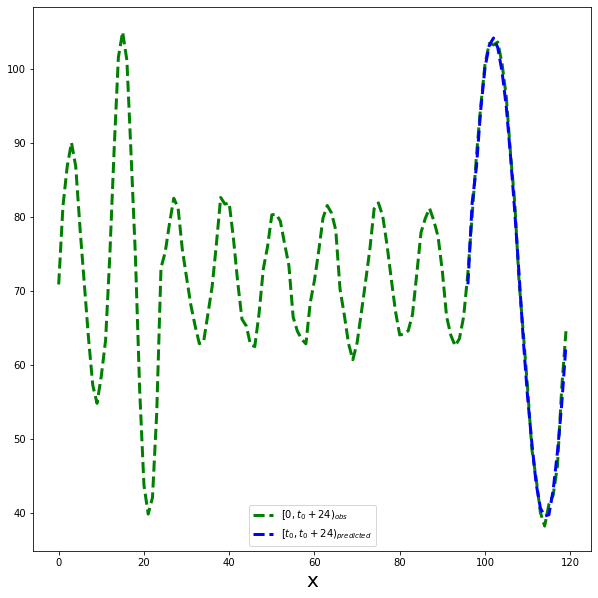

C:\Users\lpott\anaconda3\envs\NLP\lib\site-packages\torch\nn\functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


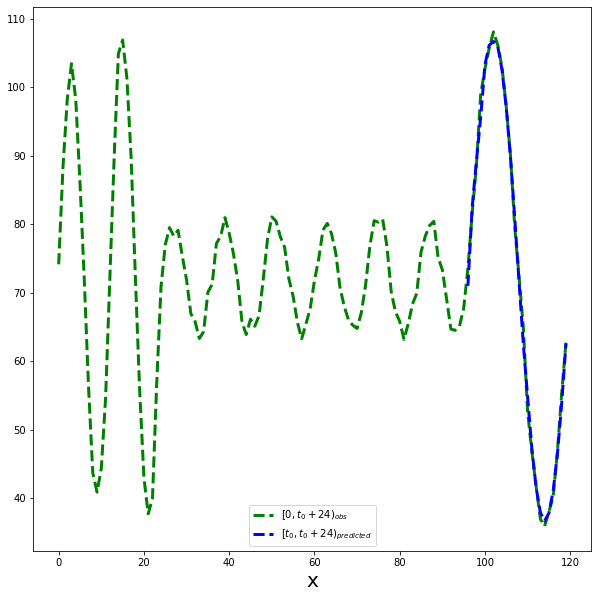

C:\Users\lpott\anaconda3\envs\NLP\lib\site-packages\torch\nn\functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [29]:
n_plots = 5
t0=96
with torch.no_grad():
    LSTM.eval()
    for step,(x,y,_) in enumerate(test_dl):
        x = x.cuda()
        y = y.cuda()

        output = LSTM(x,y)


        if step > n_plots:
            break

        with torch.no_grad():
            plt.figure(figsize=(10,10))
            plt.plot(x[0].cpu().detach().squeeze().numpy(),y[0].cpu().detach().squeeze().numpy(),'g--',linewidth=3)    
            plt.plot(x[0,t0:].cpu().detach().squeeze().numpy(),output[0,(t0-1):(t0+24-1)].cpu().detach().squeeze().numpy(),'b--',linewidth=3)

            plt.xlabel("x",fontsize=20)
            plt.legend(["$[0,t_0+24)_{obs}$","$[t_0,t_0+24)_{predicted}$"])
            plt.show()